In this notebook: replace razor pdf with weibull distribution

In [1]:
import os
os.environ['THEANO_FLAGS'] = "device=cpu"

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import theano as th
import theano.tensor as T
import pymc3 as pm
import pickle
import csv
from statistics import median
from mpl_toolkits.mplot3d import axes3d

th.config.compute_test_value = 'ignore'

In [2]:
# Get the data
boxes = ['MultiJet', 'DiJet', 'LeptonMultiJet', 'LeptonJet']
sideband_x = {'MultiJet':650, 'DiJet':650, 'LeptonMultiJet':550, 'LeptonJet':550}
sideband_y = {'MultiJet':0.3, 'DiJet':0.3, 'LeptonMultiJet':0.2, 'LeptonJet':0.2}
btag_max = {'MultiJet':3, 'DiJet':2, 'LeptonMultiJet':3, 'LeptonJet':2}
data = { box:pd.read_csv("data/RazorFitInstance_Razor2016_MoriondRereco_{}.csv".format(box), index_col='NBtags')
           for box in boxes }
sideband_data = { box:data[box][ (data[box]['MR'] < sideband_x[box]) | (data[box]['Rsq'] < sideband_y[box]) ]
                    for box in boxes}

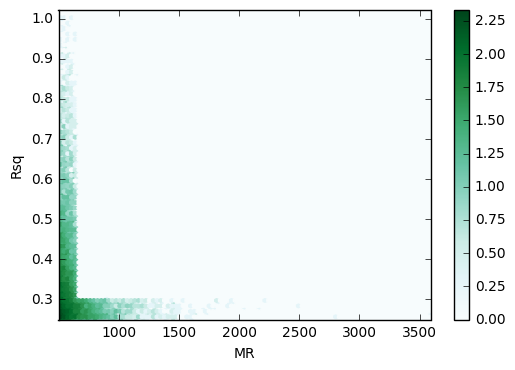

In [3]:
# Check the data
ax = sideband_data['MultiJet'].plot(kind='hexbin', x='MR', y='Rsq', bins='log', sharex=False);
plt.show()

In [4]:
class Sideband(object):
    """Class storing razor sideband geometry info."""
    def __init__(self, MRMin=500, MRMax=4000, RsqMin=0.25, RsqMax=1.5, 
                MRSidebandMax=650, RsqSidebandMax=0.30):
        self.MRMin = T.as_tensor_variable(MRMin)
        self.MRMax = T.as_tensor_variable(MRMax)
        self.RsqMin = T.as_tensor_variable(RsqMin)
        self.RsqMax = T.as_tensor_variable(RsqMax)
        self.MRSidebandMax = T.as_tensor_variable(MRSidebandMax)
        self.RsqSidebandMax = T.as_tensor_variable(RsqSidebandMax)
        
        # as floats
        self.MRMin_ = MRMin
        self.MRMax_ = MRMax
        self.RsqMin_ = RsqMin
        self.RsqMax_ = RsqMax
        self.MRSidebandMax_ = MRSidebandMax
        self.RsqSidebandMax_ = RsqSidebandMax
        
    def in_sideband(self, MR, Rsq):
        not_in = ( (MR < self.MRMin) + (MR > self.MRMax) + (Rsq < self.RsqMin) + (Rsq > self.RsqMax) 
                  + ((MR > self.MRSidebandMax)*(Rsq > self.RsqSidebandMax)) )
        return not_in < 1
        
hadronic_sideband = Sideband(500, 4000, 0.25, 1.5, 650, 0.30)
leptonic_sideband = Sideband(400, 4000, 0.15, 1.5, 550, 0.20)

hadronic_mr_sideband = Sideband(500, 650, 0.25, 1.5, 650, 1.5)
hadronic_rsq_sideband = Sideband(500, 4000, 0.25, 0.30, 4000, 0.30)

leptonic_mr_sideband = Sideband(400, 550, 0.15, 1.5, 550, 1.5)
leptonic_rsq_sideband = Sideband(400, 4000, 0.15, 0.20, 4000, 0.20)

In [5]:
def razor_p(MR, Rsq, lam, k, alpha, A, B, MRMin, RsqMin):
    """Computes razor probability density (numpy version)."""
    mag = (MR-MRMin+A) * (Rsq-RsqMin+B)
    myexp = -np.power(mag / lam, k)
    prob = alpha * (k/lam) * np.power(mag/lam, k-1) * np.power(1-np.exp(myexp), alpha-1) * np.exp(myexp) 
    return prob

def razor_int(lam, k, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sideband):
    """Computes razor integral in a rectangular region"""
    func = lambda y, x: razor_p(x, y, lam, k, alpha, A, B, sideband.MRMin_, sideband.RsqMin_)
    RsqLow = lambda x: RsqMin
    RsqHigh = lambda x: RsqMax
    return sp.integrate.dblquad(func, MRMin, MRMax, RsqLow, RsqHigh)[0]

def razor_norm(lam, k, alpha, A, B, sideband):
    norm_MR_sideband = razor_int(lam, k, alpha, A, B, sideband.MRMin_, sideband.MRSidebandMax_, 
                                          sideband.RsqMin_, sideband.RsqMax_, sideband)
    norm_Rsq_sideband = razor_int(lam, k, alpha, A, B, sideband.MRSidebandMax_, sideband.MRMax_, 
                                          sideband.RsqMin_, sideband.RsqSidebandMax_, sideband)
    return norm_MR_sideband + norm_Rsq_sideband

def razor_p_sidebandnormalized(MR, Rsq, lam, k, alpha, A, B, nevents, sideband=hadronic_sideband):
    """Returns probability normalized to the given number of events in the given sideband"""
    p = razor_p(MR, Rsq, lam, k, alpha, A, B, sideband.MRMin_, sideband.RsqMin_)
    norm = razor_norm(lam, k, alpha, A, B, sideband)
    return nevents*p/norm

In [6]:
# Using scipy's integration functionality we can directly compute the razor pdf integral numerically.
# This may allow us to move to pdfs whose norm is not analytically calculable.  

class RazorIntegral(th.Op):
    """Inputs: lam, k, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin
       Output: pdf integral"""
    __props__ = ()
    epsilon = 1e-7
    
    def make_node(self, *inputs):
        inputs = [T.as_tensor_variable(inp) for inp in inputs]
        output = T.dscalar()
        return th.Apply(self, inputs, [output])
    
    def perform(self, node, inputs, output_storage):
        lam, k, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        func = lambda y, x: razor_p(x, y, lam, k, alpha, A, B, sidebandMRMin, sidebandRsqMin)
        RsqLow = lambda x: RsqMin
        RsqHigh = lambda x: RsqMax
        pdf_integral = sp.integrate.dblquad( func, MRMin, MRMax, RsqLow, RsqHigh )[0]
        
        res = output_storage[0]
        res[0] = np.array(pdf_integral)
        
    def grad(self, inputs, g):
        lam, k, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        out_grad = g[0]
        e = self.epsilon
        lam_grad = (razor_integral(lam + e, k, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(lam - e, k, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        k_grad = (razor_integral(lam, k + e, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(lam, k - e, alpha, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        alpha_grad = (razor_integral(lam, k, alpha + e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(lam, k, alpha - e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        A_grad = (razor_integral(lam, k, alpha, A + e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(lam, k, alpha, A - e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        B_grad = (razor_integral(lam, k, alpha, A, B + e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(lam, k, alpha, A, B - e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        MRMin_grad = MRMin.zeros_like()
        MRMax_grad = MRMax.zeros_like()
        RsqMin_grad = RsqMin.zeros_like()
        RsqMax_grad = RsqMax.zern1os_like()
        sidebandMRMin_grad = sidebandMRMin.zeros_like()
        sidebandRsqMin_grad = sidebandRsqMin.zeros_like()
        return [out_grad * gr for gr in [lam_grad, k_grad, alpha_grad, A_grad, B_grad, 
                                         MRMin_grad, MRMax_grad, RsqMin_grad, RsqMax_grad,
                                         sidebandMRMin_grad, sidebandRsqMin_grad]]
        
razor_integral = RazorIntegral()

In [7]:
# Create PyMC3 class for razor PDF
from pymc3.distributions import Continuous
from pymc3.distributions.dist_math import bound

class Razor(Continuous):
    def __init__(self, lam, k, alpha, A, B, sideband, **kwargs):
        super(Razor, self).__init__(**kwargs)
        self.lam = lam
        self.k = k
        self.alpha = alpha
        self.A = A
        self.B = B
        self.sideband = sideband
    
    def norm(self):
        lam = self.lam
        k = self.k
        alpha = self.alpha
        A = self.A
        B = self.B
        norm_MR_sideband = razor_integral(lam, k, alpha, A, B, self.sideband.MRMin, self.sideband.MRSidebandMax, 
                                          self.sideband.RsqMin, self.sideband.RsqMax, self.sideband.MRMin, self.sideband.RsqMin)
        norm_Rsq_sideband = razor_integral(lam, k, alpha, A, B, self.sideband.MRSidebandMax, self.sideband.MRMax, 
                                          self.sideband.RsqMin, self.sideband.RsqSidebandMax, self.sideband.MRMin, self.sideband.RsqMin)
        return norm_MR_sideband + norm_Rsq_sideband

    def logp(self, values):
        MR = values[:,0]
        Rsq = values[:,1]
        lam = self.lam
        k = self.k
        alpha = self.alpha
        A = self.A
        B = self.B
        MRMin = self.sideband.MRMin
        RsqMin = self.sideband.RsqMin
        
        mag = (MR-MRMin+A) * (Rsq-RsqMin+B)
        myexp = -T.pow(mag / lam, k)
        logprob = (T.log(alpha) 
                 + T.log(k/lam) 
                 + (k-1) * T.log(mag/lam) 
                 + (alpha-1) * T.log(1-T.exp(myexp)) 
                 + myexp) 
        lognorm = T.log(self.norm())
        return bound(logprob - lognorm, A>0, B>0, lam>0, k>0., alpha>0.)

In [8]:
# Get nsigma values in every sideband bin

bins_hadronic = ([500, 575, 650, 750, 900, 1200, 1600, 2500, 4000], [0.25,0.30,0.41,0.52,0.64,1.5])
bins_leptonic = ([400, 475, 550, 700, 900, 1200, 1600, 2500, 4000], [0.15,0.20,0.25,0.30,0.41,0.52,0.64,1.5])

def get_data_yield(d, bin_coords):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    return len(d[ (d['MR'] > mrmin) & (d['MR'] < mrmax) & (d['Rsq'] > rsqmin) & (d['Rsq'] < rsqmax) ])

def get_pred_yields(trace, bin_coords, sband, norm):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    yields = []
    for i in range(len(trace)):
        lam = trace['lam'][i]
        k = trace['k'][i]
        alpha = trace['alpha'][i]
        A = trace['A'][i]
        B = trace['B'][i]
        full_int = razor_norm(lam, k, alpha, A, B, sband)
        yields.append( razor_int(lam, k, alpha, A, B, mrmin, mrmax, rsqmin, rsqmax, sband)*norm/full_int )
    return np.array(yields)

def get_nsigma(obs, preds):
    central_pred = median(preds)
    total = float(len(preds))
    if obs > central_pred:
        cdf = 1 - len(preds[preds > obs])/total
    else:
        cdf = len(preds[preds < obs])/total
    print obs, central_pred, sp.stats.iqr(preds), cdf, sp.stats.norm.ppf(cdf)
    return sp.stats.norm.ppf(cdf)

def get_nsigmas(trace, d, box):
    bins = bins_hadronic
    sband = hadronic_sideband
    if 'Lepton' in box:
        bins = bins_leptonic
        sband = leptonic_sideband
    norm = len(d)
    nsigmas = {}
    for ix, mrlow in enumerate(bins[0][:-1]):
        mrhigh = bins[0][ix+1]
        # only consider bins in sideband (2 bins in MR, 1 in Rsq)
        if ix < 2:
            iymax = len(bins[1])-1
        else:
            iymax = 1
        for iy, rsqlow in enumerate(bins[1][:iymax]):
            rsqhigh = bins[1][iy+1]
            this_bin = (mrlow, mrhigh, rsqlow, rsqhigh)
            this_yield = get_data_yield(d, this_bin)
            this_preds = get_pred_yields(trace, this_bin, sband, norm)
            nsigmas[this_bin] = get_nsigma(this_yield, this_preds)
    return nsigmas

In [9]:
# Model setup and training

def build_model(data, nbtags, box='MultiJet',
               prior_slopes=[10., 1.0, 0.0001, 0.0005, 1.0],
               initial_vals=[0.00023, 0.23, 102., 1000., 0.097],
               sideband=None):
    """Create PyMC3 model with razor pdf and observed data.
        prior_slopes: slopes for the exponential priors on lam, k, alpha, A, B
        initial_vals: test values for parameters"""
    with pm.Model() as model:
        # PDF variables
        hyper_lam = pm.Gamma("hyper_lam", mu=prior_slopes[0], sd=100*prior_slopes[0], testval=prior_slopes[0])
        hyper_k = pm.Gamma("hyper_k", mu=prior_slopes[1], sd=100*prior_slopes[1], testval=prior_slopes[1])
        hyper_alpha = pm.Gamma("hyper_alpha", mu=prior_slopes[2], sd=100*prior_slopes[2], testval=prior_slopes[2])
        hyper_A = pm.Gamma("hyper_A", mu=prior_slopes[3], sd=100*prior_slopes[3], testval=prior_slopes[3])
        hyper_B = pm.Gamma("hyper_B", mu=prior_slopes[4], sd=100*prior_slopes[4], testval=prior_slopes[4])
        
        lam = pm.Exponential("lam", hyper_lam, testval=initial_vals[0])
        k = pm.Exponential("k", hyper_k, testval=initial_vals[1])        
        alpha = pm.Exponential("alpha", hyper_alpha, testval=initial_vals[2])
        A = pm.Exponential("A", hyper_A, testval=initial_vals[3])
        B = pm.Exponential("B", hyper_B, testval=initial_vals[4])
            
        if sideband is not None:
            sband = sideband
        elif box in ['LeptonJet','LeptonMultiJet']:
            sband = leptonic_sideband
        else:
            sband = hadronic_sideband
            
        observed = data.ix[nbtags][['MR','Rsq']].values
        razor_pdf = Razor("razor_pdf", lam=lam, k=k, alpha=alpha, A=A, B=B, sideband=sband,
                          shape=len(observed), observed=observed)
    return model

def fit_model(model, samples=10000, burn_period=5000):
    """Fit the model and return
        samples from the posterior"""
    with model:
        step = pm.Metropolis()
        trace = pm.sample(samples, step=step)
        burned_trace = trace[burn_period:]
    return burned_trace
    
def visualize_trace(trace):
    varnames = ['lam','k','alpha','A','B']
    varnames += ['hyper_{}'.format(v) for v in varnames]
    # Visualize posteriors and MCMC traces
    pm.plots.traceplot(trace=trace, varnames=varnames);
    plt.show()
    # Plot the autocorrelation of the MCMC traces.
    # Long tails on this plot mean that the Markov chain is not sampling uniformly from the posterior.
    pm.plots.autocorrplot(trace=trace, varnames=varnames);
    plt.show()
    # Visualize the posteriors for the function parameters
    pm.plot_posterior(trace=trace, varnames=varnames);
    plt.show()
    
def fit_and_plot(data, nbtags, samples=10000, burn_period=5000, sideband=None, box='MultiJet'):
    """Build the model, fit it, and make diagnostic plots.
        Returns the MCMC trace."""
    model = build_model(data, nbtags, sideband=sideband, box=box)
    trace = fit_model(model, samples, burn_period)
    visualize_trace(trace)
    return trace

def save_traces(traces, fname):
    pickle.dump(traces, open(fname, "wb"))
    
def load_traces(fname):
    return pickle.load(open(fname, "rb"))


  1%|          | 15/2000 [00:03<06:24,  5.16it/s]

  8%|▊         | 152/2000 [00:29<12:01,  2.56it/s]


 15%|█▌        | 303/2000 [00:56<04:39,  6.08it/s]


 23%|██▎       | 454/2000 [01:21<04:13,  6.11it/s]


 30%|███       | 605/2000 [01:46<03:48,  6.10it/s]


 38%|███▊      | 756/2000 [02:10<03:21,  6.16it/s]


 45%|████▌     | 907/2000 [02:35<02:58,  6.13it/s]


 53%|█████▎    | 1057/2000 [03:00<02:34,  6.10it/s]


 60%|██████    | 1205/2000 [04:29<02:09,  6.12it/s]


 68%|██████▊   | 1353/2000 [04:53<01:45,  6.13it/s]


 75%|███████▌  | 1501/2000 [06:17<01:24,  5.91it/s]


 82%|████████▎ | 1650/2000 [06:42<00:57,  6.12it/s]


 90%|████████▉ | 1798/2000 [07:06<00:33,  6.09it/s]


 97%|█████████▋| 1947/2000 [07:31<00:08,  6.13it/s]


100%|██████████| 2000/2000 [07:39<00:00,  6.15it/s]


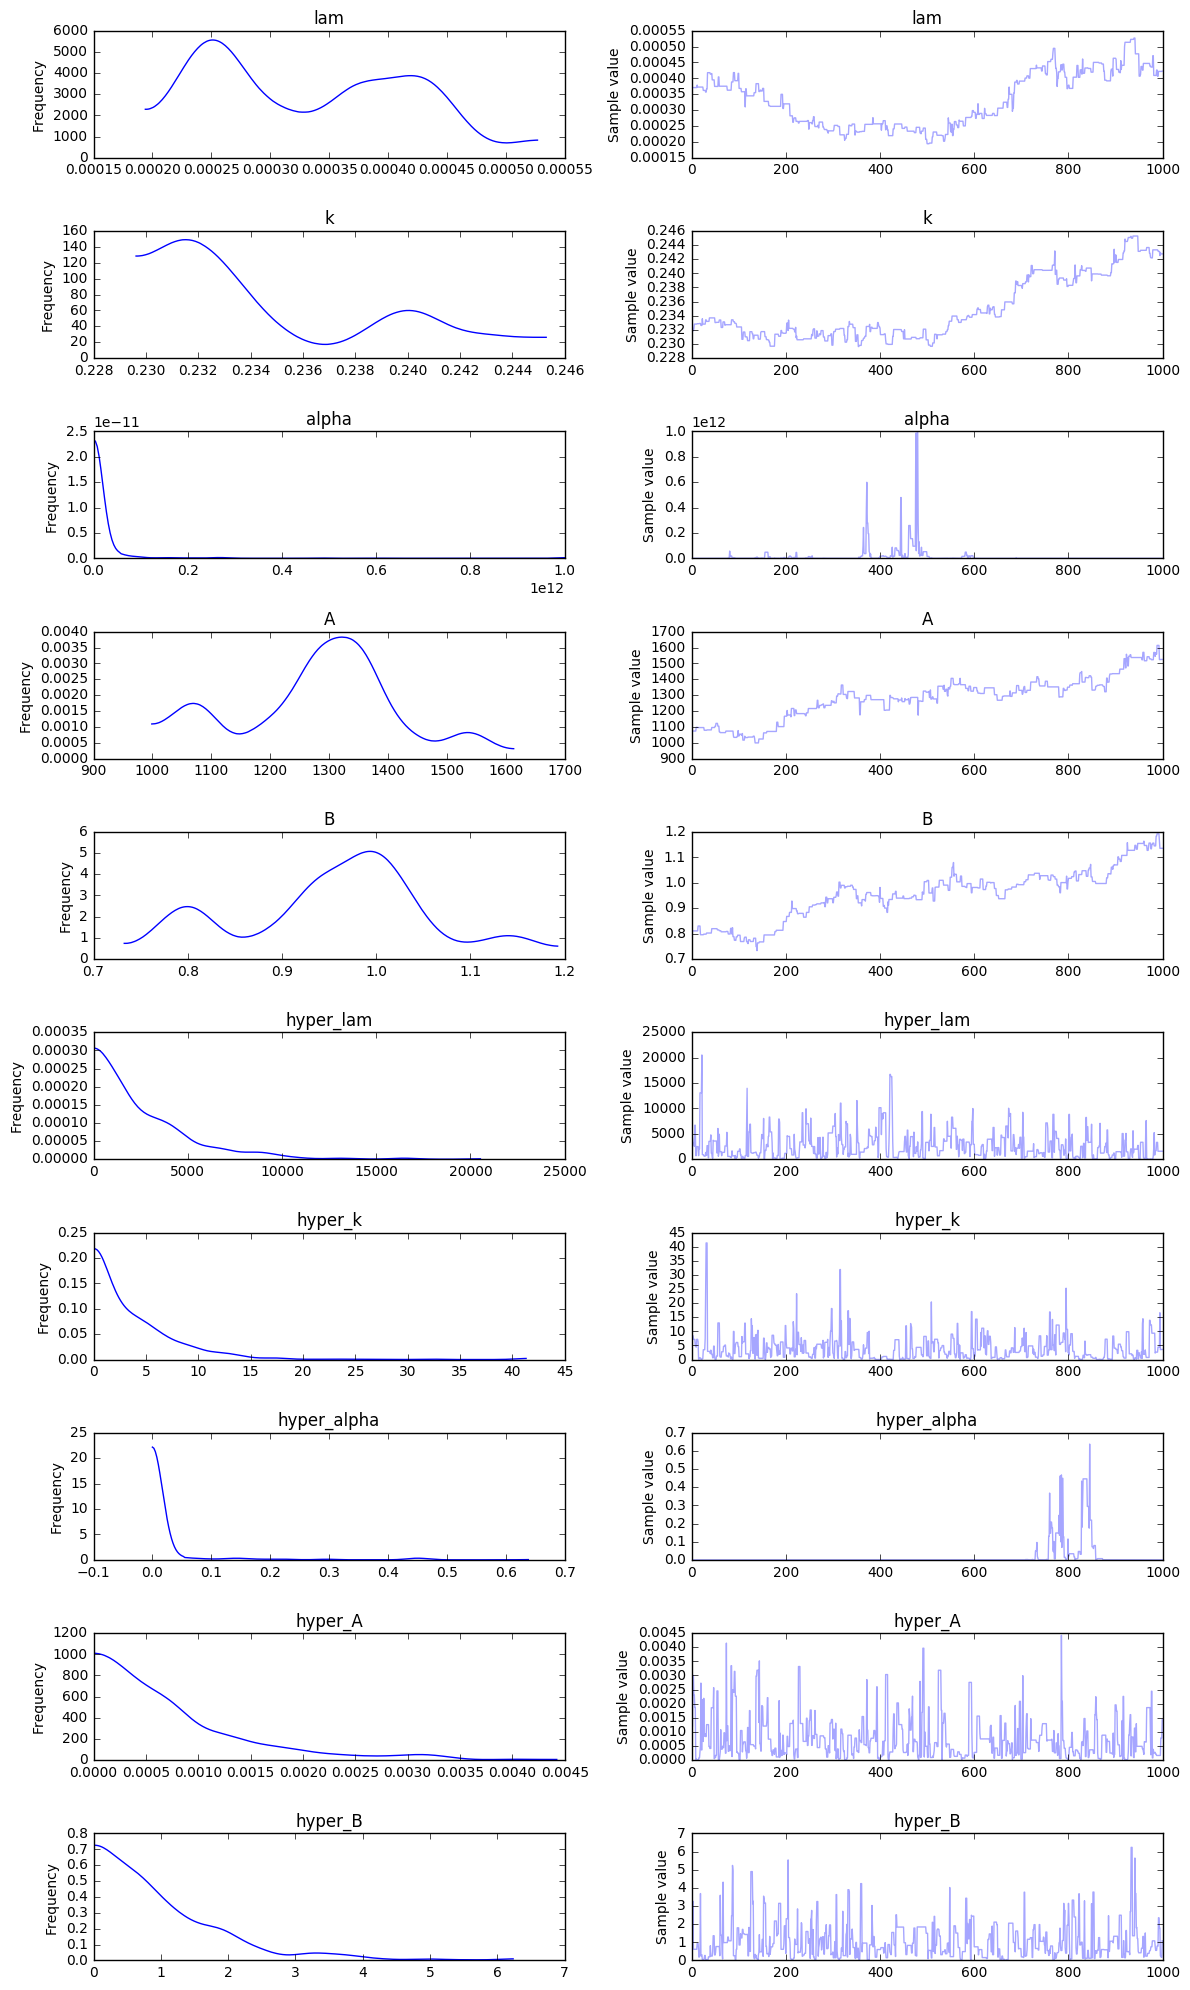

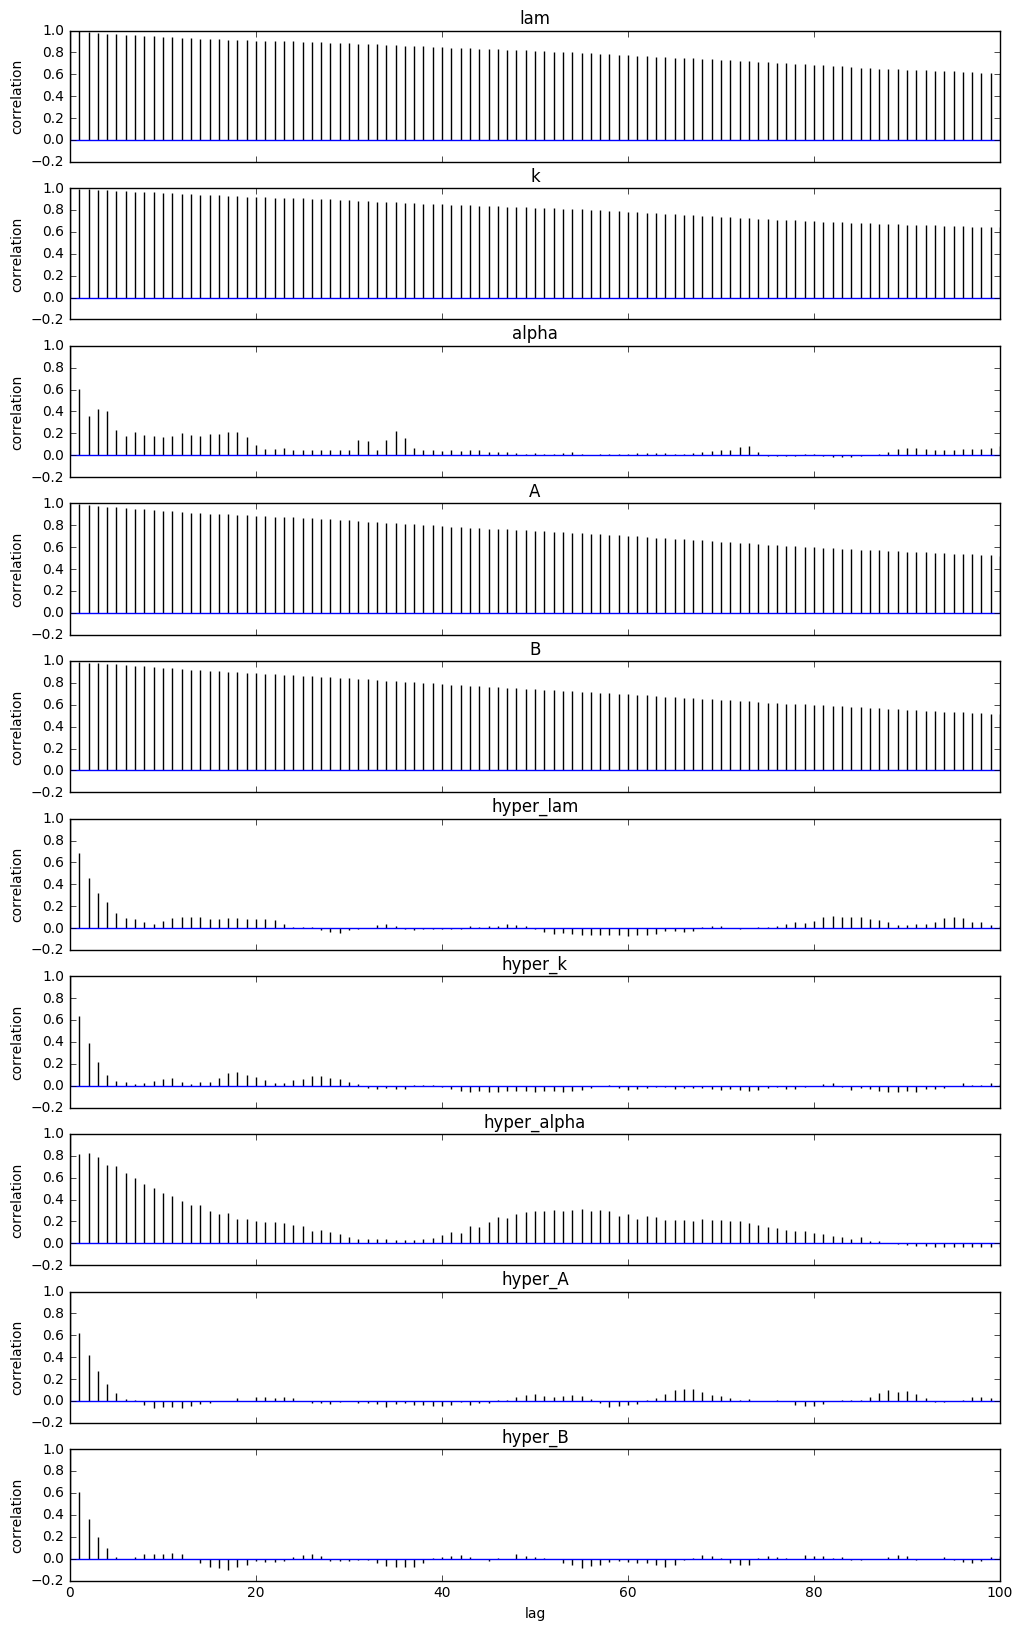

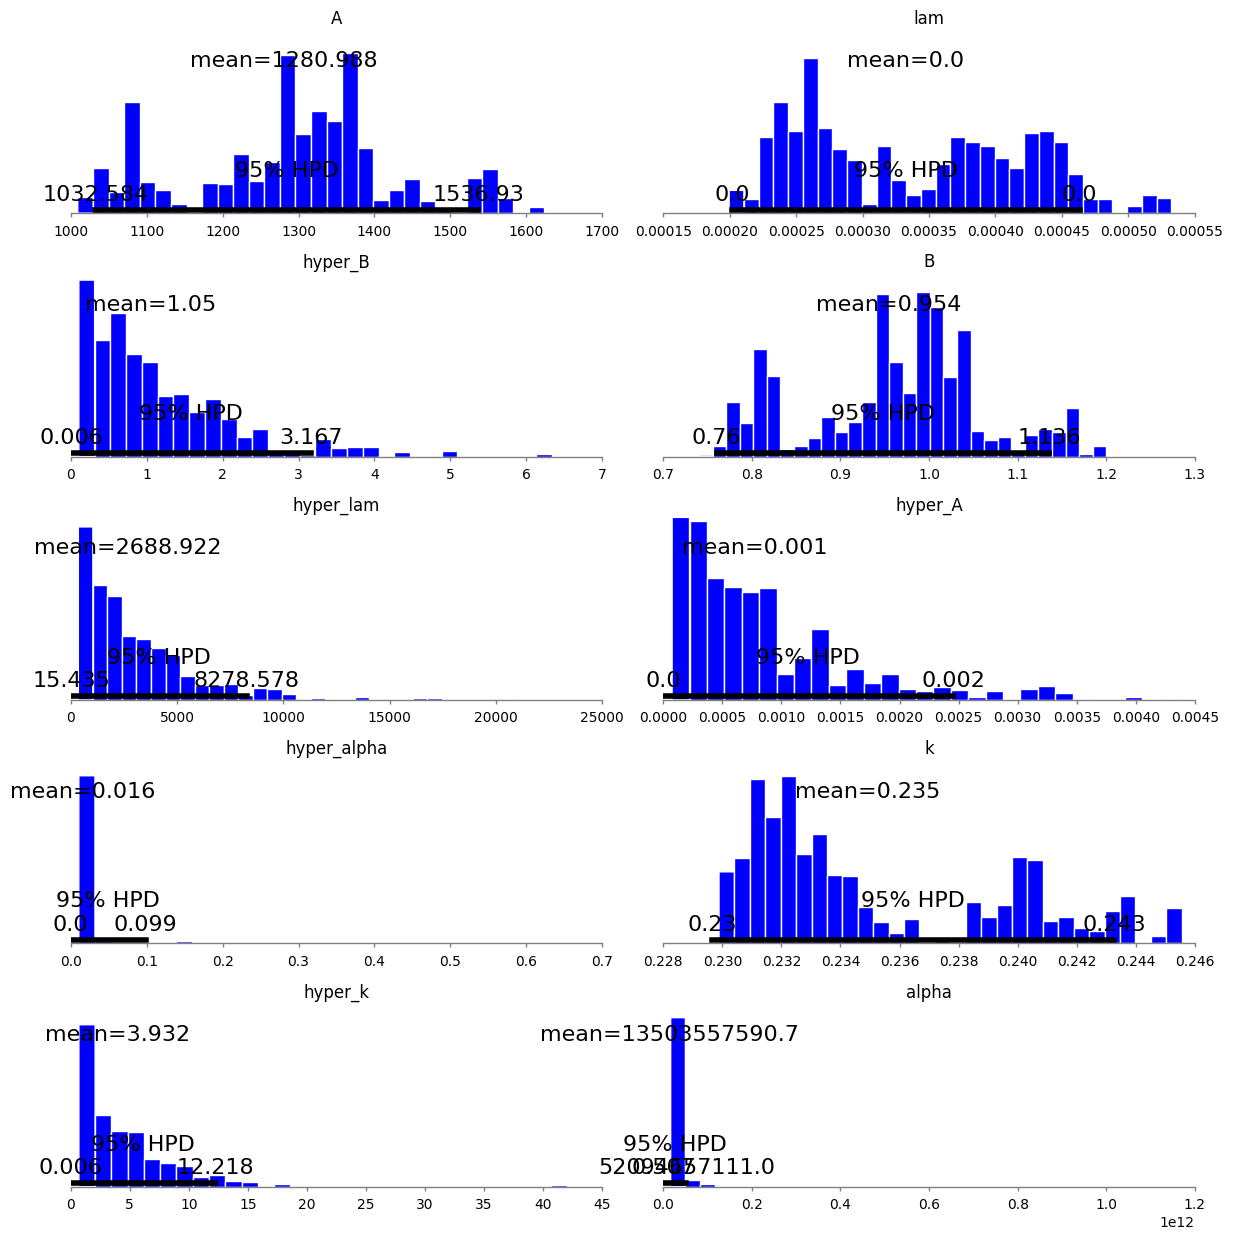

In [11]:
%matplotlib inline
trace = fit_and_plot(sideband_data['MultiJet'], 0, samples=2000, burn_period=1000, box='MultiJet')

In [12]:
get_nsigmas(trace, sideband_data['MultiJet'].ix[0], 'MultiJet')

1584 1561.65845418 29.329816804 0.842 1.00271166503
1635 1720.22246284 16.5977840545 0.0 -inf
675 675.064961899 9.73368197498 0.494 -0.0150403366786
309 300.147699431 7.32775725409 0.912 1.35317415455
259 228.678962831 11.8588291205 1.0 inf
1006 938.122429651 10.1437384428 1.0 inf
984 1026.0451196 7.74309640447 0.0 -inf
390 398.027634358 8.46405915782 0.103 -1.26464113566
199 174.731395237 5.03442878707 1.0 inf
131 130.965340429 6.82351275186 0.508 0.020054370353
708 714.148151644 9.44143679301 0.182 -0.907769529868
504 507.035950025 12.0338731149 0.384 -0.294991988223
297 308.620581727 12.8799982854 0.098 -1.29303197614
78 74.9073287965 5.81260166083 0.763 0.71598598961
15 15.5746260051 2.39882931085 0.386 -0.289759805229
2 0.647674052571 0.220046390799 1.0 inf


{(500, 575, 0.25, 0.3): 1.0027116650265493,
 (500, 575, 0.3, 0.41): -inf,
 (500, 575, 0.41, 0.52): -0.015040336678635672,
 (500, 575, 0.52, 0.64): 1.3531741545480029,
 (500, 575, 0.64, 1.5): inf,
 (575, 650, 0.25, 0.3): inf,
 (575, 650, 0.3, 0.41): -inf,
 (575, 650, 0.41, 0.52): -1.2646411356610803,
 (575, 650, 0.52, 0.64): inf,
 (575, 650, 0.64, 1.5): 0.020054370352950636,
 (650, 750, 0.25, 0.3): -0.90776952986805559,
 (750, 900, 0.25, 0.3): -0.29499198822262623,
 (900, 1200, 0.25, 0.3): -1.2930319761442421,
 (1200, 1600, 0.25, 0.3): 0.71598598961020499,
 (1600, 2500, 0.25, 0.3): -0.2897598052289142,
 (2500, 4000, 0.25, 0.3): inf}